# Hierarchical clustering basics

Learn in this tutorial how to use the `cnnclustering.cnn` module for step-wise hierarchical clusterings, where
one cluster step does not deliver a satisfactory result. We will also show how to use a data set of reduced size for cluster exploration and how we can transfer the result to the original full size data set.

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-requirements" data-toc-modified-id="Pre-requirements-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-requirements</a></span><ul class="toc-item"><li><span><a href="#Import-dependencies" data-toc-modified-id="Import-dependencies-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import dependencies</a></span></li><li><span><a href="#Notebook-configuration" data-toc-modified-id="Notebook-configuration-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Notebook configuration</a></span></li><li><span><a href="#Package-configuration" data-toc-modified-id="Package-configuration-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Package configuration</a></span></li></ul></li><li><span><a href="#Dissimilar-blobs-showcase" data-toc-modified-id="Dissimilar-blobs-showcase-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dissimilar blobs showcase</a></span><ul class="toc-item"><li><span><a href="#Getting-started" data-toc-modified-id="Getting-started-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Getting started</a></span></li><li><span><a href="#Parameter-scan" data-toc-modified-id="Parameter-scan-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Parameter scan</a></span></li><li><span><a href="#Hierarchical-clustering" data-toc-modified-id="Hierarchical-clustering-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Hierarchical clustering</a></span></li></ul></li></ul></div>

## Pre-requirements

### Import dependencies

In [1]:
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd                # Optional dependency
from sklearn import datasets       # For sklearn test data set creation
from sklearn.preprocessing import StandardScaler

import cnnclustering.cnn as cnn    # CNN clustering
import cnnclustering.cmsm as cmsm  # Core-set MSM estimation

This notebook was created using Python 3.8.

In [2]:
# Version information
print(sys.version)

3.8.3 (default, May 15 2020, 15:24:35) 
[GCC 8.3.0]


### Notebook configuration

We use `matplotlib` to create plots. A `"matplotlibrc"` file can be used to customise the appearance of the plots.

In [3]:
# Matplotlib configuration
mpl.rc_file(
    "matplotlibrc",
    use_default_template=False
)

In [4]:
# Axis property defaults for the plots
ax_props = {
    "xlabel": None,
    "ylabel": None,
    "xlim": (-2.5, 2.5),
    "ylim": (-2.5, 2.5),
    "xticks": (),
    "yticks": (),
    "aspect": "equal"
}

# Line plot property defaults
line_props = {
    "linewidth": 0,
    "marker": '.',
}

Optionally, clustering results can be nicely collected in a `pandas` data frame.

In [5]:
# Pandas DataFrame print options
pd.set_option('display.max_rows', 1000)

### Package configuration

In [6]:
# Configuration file found?
cnn.settings.cfgfile  # If None, no file is provided

In [7]:
# Display default settings
cnn.settings.defaults

{'default_cnn_cutoff': '1',
 'default_cnn_offset': '0',
 'default_radius_cutoff': '1',
 'default_member_cutoff': '2',
 'default_fit_policy': 'conservative',
 'default_predict_policy': 'conservative',
 'float_precision': 'sp',
 'int_precision': 'sp'}

## Dissimilar blobs showcase

We will generate a sample data set of three clusters that have very different point densities and are spatially not very well separated. As we will see,
it can be non-trivial to extract all three clusters with a single set of cluster parameters. We will solve the problem by extracting the clusters in a two step procedure.

### Getting started

In [8]:
# Generate blobs with quite different point densities
dblobs, _ = datasets.make_blobs(
    n_samples=int(1e5),
    cluster_std=[3.5, 0.32, 1.8],
    random_state=1
    )

dblobs = StandardScaler().fit_transform(dblobs)

In [9]:
# Initialise clustering
cobj = cnn.CNN(points=dblobs)

In [10]:
# Get basic information about the cnn.CNN instance via cobj.__str__()
print(cobj)

CNN cluster object
--------------------------------------------------------------------------------
Alias :                         root
Hierachy level :                0

Data point shape :              Parts      - 1
                                Points     - 100000
                                Dimensions - 2

Distance matrix calculated :    None
Neighbourhoods calculated :     None
Density graph calculated :      None

Clustered :                     False
Children :                      False



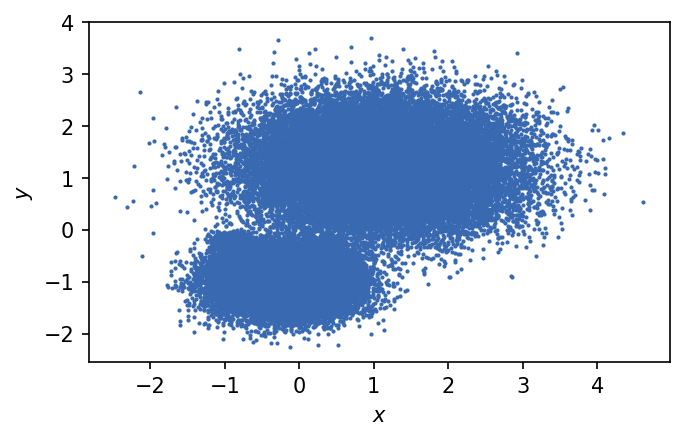

In [11]:
# Plot the original data
_ = cobj.evaluate()

Looking at the 2D plot of the generated points above we can already tell that this is probably not the easiest
of all clustering problems. One of the three clusters is hardly visible. We also have generated a fairly large amount of data points. If we have a big amount of computer-memory or enough time, we can attempt to cluster the 100,000 points directly. In terms of speed and for data exploration it might be, however, a good idea to perform the clustering on a reduced data set. We can predict the clustering later for the full sized set on the basis of the reduced result.

In [12]:
# To make the clustering easier, reduce the number of points
# (start, stop, stride)
robj = cobj.cut(points=(None, None, 100))
# Equivalent to:
#     >>> robj = cnn.CNN(points=cobj.data.points[slice(None, None, 100), :])

In [13]:
print(robj)

CNN cluster object
--------------------------------------------------------------------------------
Alias :                         root
Hierachy level :                0

Data point shape :              Parts      - 1
                                Points     - 1000
                                Dimensions - 2

Distance matrix calculated :    None
Neighbourhoods calculated :     None
Density graph calculated :      None

Clustered :                     False
Children :                      False



We created a cluster object holding a smaller data set by using a point stride of 100, leaving us with only 1000 points that can be clustered very fast. Note, that using a slice on the original data like this does not require a copy. A plot of the reduced set also shows that we made the clustering easier just judging by visual inspection. We can now clearly spot three point clouds.

Text(0.5, 1.0, '1000 points')

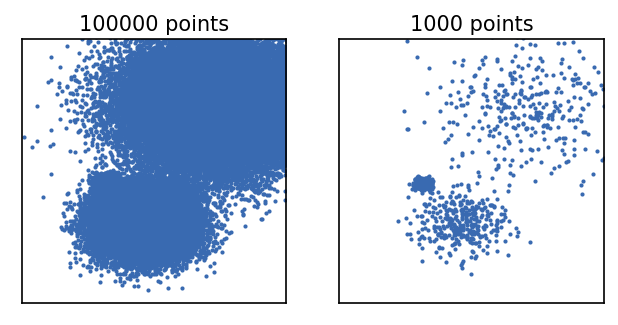

In [14]:
# Plot the reduced data
fig, Ax = plt.subplots(1, 2)
_ = cobj.evaluate(ax=Ax[0], ax_props=ax_props)
_ = robj.evaluate(ax=Ax[1], ax_props=ax_props)
Ax[0].set_title(f"{cobj.data.points.shape[0]} points", fontsize=10, pad=4)
Ax[1].set_title(f"{robj.data.points.shape[0]} points", fontsize=10, pad=4)

When we pre-calculate pairwise point distances, we can plot the distribution of distances. This can give us a very basic estimate for a reasonable radius cutoff as one of the cluster parameters. For globular clusters, each cluster should be visible as a peak in the distance distribution around a value that is very roughly equivalent to the radius of the point cloud. For more complicated data sets this approximation is not valid, but we can still get a feeling for the value range of the radius cutoff.

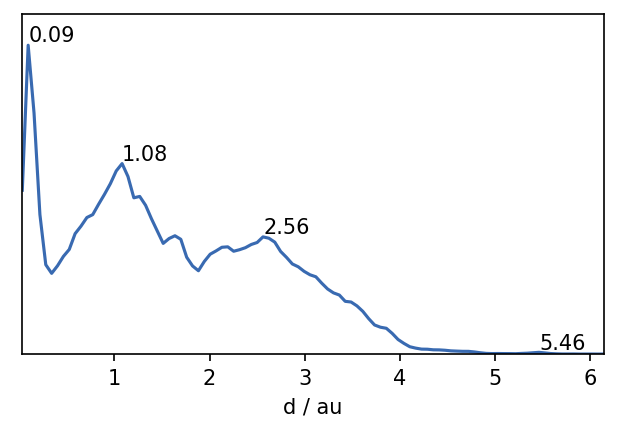

In [15]:
# Looking at the distance distribution between points, can help to find
# an initial value for the radius cutoff
robj.calc_dist()  # Pre-calculate distances
fig, ax, *_ = robj.dist_hist(maxima=True, maxima_props={"order": 5})

### Parameter scan

Blindly starting to cluster a data set in a happy-go-lucky attempt may already lead to a satisfactory result in some cases, but let's tackle this problem in more systematic way, to see how different cluster parameters effect the outcome. This will take a few seconds to complete.

In [16]:
# A scan of a few parameters shows that it is difficult to extract the
# three clusters at once with one parameter set
for r in [0.05, 0.08, 0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.75, 1., 2.]:
    for c in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
        robj.fit(r, c, v=False)  # fit from pre-calculated distances

Each cluster result will be added to the `summary` attribute of our cluster object.

In [17]:
print(*robj.summary[:5], sep="\n")

CNNRecord(points=1000, r=0.05, c=0, min=2, max=None, clusters=Labels(111), largest=0.329, noise=0.332, time=0.010924577713012695)
CNNRecord(points=1000, r=0.05, c=1, min=2, max=None, clusters=Labels(31), largest=0.326, noise=0.544, time=0.010438919067382812)
CNNRecord(points=1000, r=0.05, c=2, min=2, max=None, clusters=Labels(14), largest=0.317, noise=0.627, time=0.010040998458862305)
CNNRecord(points=1000, r=0.05, c=3, min=2, max=None, clusters=Labels(8), largest=0.315, noise=0.664, time=0.010024070739746094)
CNNRecord(points=1000, r=0.05, c=4, min=2, max=None, clusters=Labels(3), largest=0.312, noise=0.684, time=0.01040029525756836)


If you have `pandas` installed, you can convert the summary to a nice table as a `pandas.DataFrame`. This makes the analysis of the cluster results more convenient.

In [18]:
# Get summary sorted by number of identified clusters
df = robj.summary.to_DataFrame().sort_values('clusters')
# Show cluster results where we have 3 clusters
df[df.clusters == 3]

,points,r,c,min,max,clusters,largest,noise,time
52,1000,0.200,15,2,<NA>,3,0.334,0.464,0.055377
86,1000,0.400,5,2,<NA>,3,0.956,0.039,0.070035
96,1000,0.450,10,2,<NA>,3,0.668,0.058,0.068890
35,1000,0.125,20,2,<NA>,3,0.330,0.659,0.035683
83,1000,0.400,2,2,<NA>,3,0.981,0.015,0.064144
81,1000,0.400,0,2,<NA>,3,0.991,0.004,0.068568
70,1000,0.300,15,2,<NA>,3,0.629,0.272,0.058881
4,1000,0.050,4,2,<NA>,3,0.312,0.684,0.010400
65,1000,0.300,2,2,<NA>,3,0.950,0.042,0.054430


The summary shows indeed that we got 3 clusters (as desired) for a few parameter combinations. Apart from the number of clusters, it is, however often also of interest, how many data points ended up in the clusters and how many are considered outliers (noise). In this case we expect 3 clusters of more or less equal size (member wise) and we may be interested to keep the outliers-level low. Of the results giving 3 clusters, 3 find the largest cluster to entail one third of the data points (which is good), but the noise level is around 50 % and higher (which is probably not what we want). Let's plot a few results to see what is going on here.

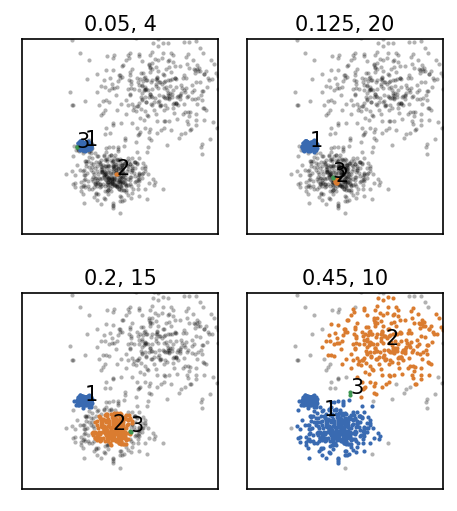

In [19]:
# Cluster attempts in comparison
fig, ax = plt.subplots(2, 2)
Ax = ax.flatten()
for i, pair in enumerate([(0.050, 4), (0.125, 20), (0.2, 15), (0.450, 10)]):
    robj.fit(*pair, rec=False)
    _ = robj.evaluate(ax=Ax[i], ax_props=ax_props)
    Ax[i].set_title(f'{pair[0]}, {pair[1]}', fontsize=10, pad=4)

fig.subplots_adjust(
    left=0.2, right=0.8, bottom=0, top=1, wspace=0, hspace=0.3 
    )

None of the above attempts was able to achieve a split into 3 clusters as we wanted it. One could now try to tinker around with the parameters a bit more, or resort to hierarchical clustering. As we see in the plots above (lower left and right), two different parameter pairs are leading to a clean split of different regions of the data, so why not apply both of them, one after the other.

Before we do this let's have another close look at the cluster results we obtained. Using the `smmarize` method of a cluster object, we can visualize a summary table in a 2D contour plot, to evaluate the quality measures *identified cluster number*, *members in the largest cluster*, *points classified as outliers* and *computational time of the fit* versus the input parameters *radius cutoff* (*r*) and *similarity criterion* (*c*).  

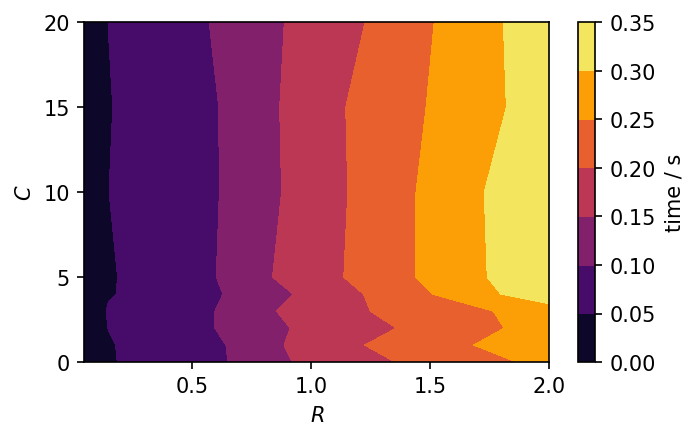

In [20]:
# Summarize the summary table as 2D contour plot
# time
fig, ax = plt.subplots()
contour = robj.summary.summarize(ax=ax)[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax)
ax.set_yticks([0, 5, 10, 15, 20])
colorbar.set_label("time / s")

From the *time vs. R/C* plot we can see how the total clustering time depends in particular on the neighbour search radius cutoff. Larger radii result in larger neighbourlists for each point increasing the processing time, so if one has the choice smaller values for *r* should be preferred.

(0.05, 1.0)

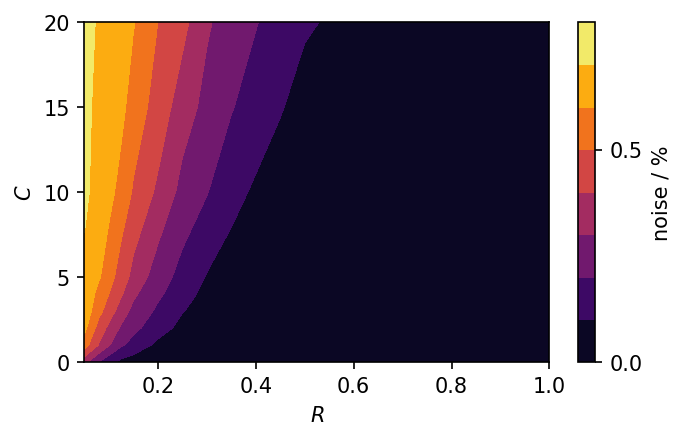

In [21]:
# Summarize the summary table as 2D contour plot
# noise
fig, ax = plt.subplots()
contour = robj.summary.summarize(ax=ax, quant="noise")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 0.5, 1))
ax.set_yticks([0, 5, 10, 15, 20])
colorbar.set_label("noise / %")
ax.set_xlim(None, 1)

The ratio of outlier-points depends on the search radius *r* as well as on the similarity criterion *c*. We can somewhat denote from this that cluster results with a similar noise-ratio (that are presumably similar qualitatively) are achieved for a variety of *r*/*c* combinations. If we increase *r* and *c* at the same time, the noise-level stays constant. The desired amount of noise depends much on the nature of the underlying data set. 

(0.05, 1.0)

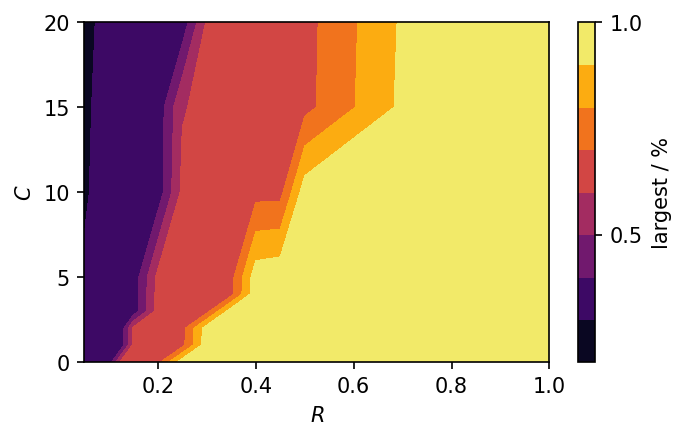

In [22]:
# Summarize the summary table as 2D contour plot
# largest cluster
fig, ax = plt.subplots()
contour = robj.summary.summarize(ax=ax, quant="largest")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 0.5, 1))
ax.set_yticks([0, 5, 10, 15, 20])
colorbar.set_label("largest / %")
ax.set_xlim(None, 1)

The ratio of points assigned to the largest cluster show a similar trend as the noise-ratio. This view could give a good hint towards reasonable parameter combinations if one already has an idea about the expected cluster size. It also shows for which parameters we do not observe any splitting (about 100 % of the points are in the largest cluster. 

(0.05, 1.0)

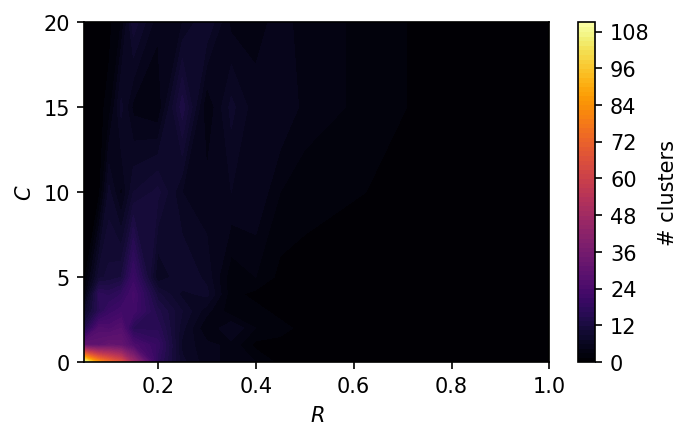

In [23]:
# Summarize the summary table as 2D contour plot
# cluster number
fig, ax = plt.subplots()
contour = robj.summary.summarize(ax=ax, quant="clusters",
                         contour_props={"levels": 100})[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax)
ax.set_yticks([0, 5, 10, 15, 20])
colorbar.set_label("# clusters")
ax.set_xlim(None, 1)

(0.05, 1.0)

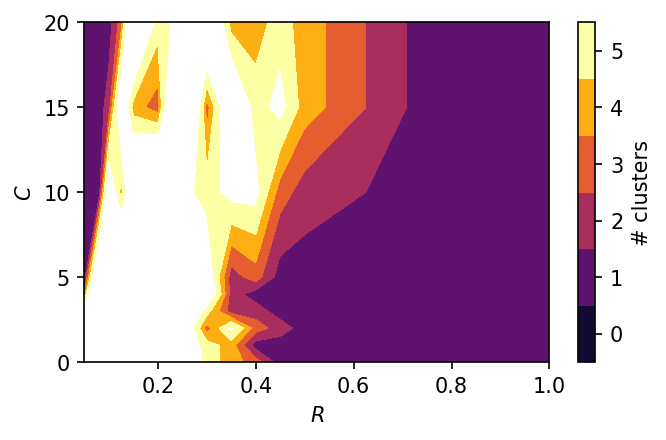

In [24]:
# Summarize the summary table as 2D contour plot
# cluster number with adjusted coloring
fig, ax = plt.subplots()
contour = robj.summary.summarize(
    ax=ax, quant="clusters",
    contour_props={"levels": [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5],
                   "vmax": 5}
    )[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 1, 2, 3, 4, 5))
ax.set_yticks([0, 5, 10, 15, 20])
colorbar.set_label("# clusters")
ax.set_xlim(None, 1)

The probably most telling view is given by the *number of clusters* plots. The analysis demonstrates nicely that for this data set a splitting into 3 meaningful clusters is hard to achieve.

### Hierarchical clustering

To use the hierarchical approach to clustering our data set, we will apply in a first step a pair of cluster parameters that will extract the lesser dense region of the data as an isolated cluster. That is we choose a comparably large value of the neighbour search radius *r* and a rather low value of the similarity criterion *c*. We can refer to these parameters as *soft* parameters, leaving the more dense regions of the data untouched and in one cluster. Remember that density in terms of the CNN clustering is estimated as the number of common neighbours within the neighbourhood intersection of two points with respect to a radius *r*. So more common neighbours (higher similarity cutoff *c*) and/or a smaller neighbourhood radius (smaller *r*) will result in a higher density requirement. To make this more clear let's have a look again at some clusterings. 

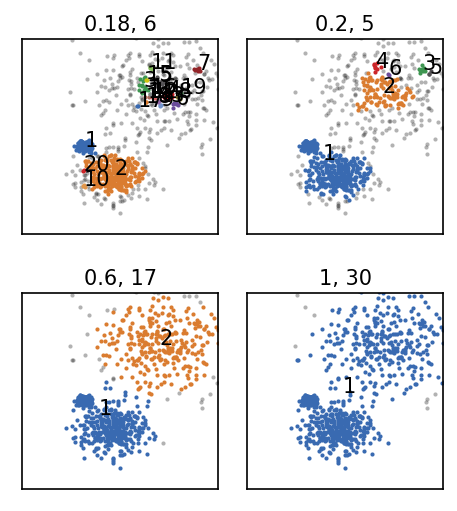

In [25]:
# Cluster attempts in comparison
fig, ax = plt.subplots(2, 2)
Ax = ax.flatten()
for i, pair in enumerate([(0.18, 6), (0.2, 5), (0.6, 17), (1, 30)]):
    robj.fit(*pair, rec=False)
    _ = robj.evaluate(ax=Ax[i], ax_props=ax_props)
    Ax[i].set_title(f'{pair[0]}, {pair[1]}', fontsize=10, pad=4)

fig.subplots_adjust(
    left=0.2, right=0.8, bottom=0, top=1, wspace=0, hspace=0.3 
    )

__Lower right__: Choosing a high radius cutoff ($r=1$, ), a soft density requirement, results in no cluster splitting. The data set as a whole forms cluster in which the point density is *at least* as high as our density requirement.

__Lower left__: When we increase the density requirement ($r=0.6$, $c=17$), we observe a splitting between the broadly distributed lower density cluster and the more dense clusters. Within both the resulting clusters the point density is higher than required by the parameters but they are separated by a low density region and therefore split. This parameter set can be used for the first step of the hierarchical clustering.

__Upper right__: Increasing the density requirement further ($r=0.2$, $c=5$), leads to a splitting within the broad cluster first, while the more dense clusters still remain united. Obviously, the point density in the region between the two dense clusters is higher than in parts within the low density cluster.

__Upper left__: Choosing parameters hard enough ($r=0.18$, $c=6$) to achieve a splitting of the two dense clusters, does also completely split up the less dense cluster. We could use this parameter set in a second hierarchical clustering step.

The central element of the hierarchical cluster functionality is the `isolate` method of a cluster object. After a clustering (with soft parameters) we can *freeze* the result before we start to re-cluster. 

In [26]:
# After the first step, we need to isolate the cluster result
robj.fit(0.6, 17, rec=False)
robj.isolate()

The `isolate` method will create a new cluster object (a child cluster) for every cluster of a cluster result.
In our case we get two new child clusters (plus one for outliers). The clusters are stored in a dictionary under the `children` attribute of the parent cluster object.

In [27]:
# The children dictionary of the data after isolation holds
# a cluster object for each cluster found in the last step
robj.children

defaultdict(<function cnnclustering.cnn.CNN.isolate.<locals>.<lambda>()>,
            {1: <cnnclustering.cnn.CNNChild at 0x7f9086d3ba30>,
             2: <cnnclustering.cnn.CNNChild at 0x7f9086d3bd00>,
             0: <cnnclustering.cnn.CNNChild at 0x7f9086d3beb0>})

Since we will use different cluster parameters now for different clusters it would be nice to have something
to keep the overview of which cluster has been identified under which parameters. This information is provided by `labels.info`. A label info tells us three things:

  - `origin`: How have these labels been assigned? The entry `"fitted"` means, they were obtained by a regular clustering.
  - `reference`: This is a related clustering object, i.e. the object that is associated to the data for which the labels are valid. For `"fitted"` labels this is a reference to the clustering object itself that carries the labels.
  - `params`: This is a dictionary stating the cluster parameters (*r*, *c*) that led to each cluster. For `"fitted"` labels, each cluster has the same parameters.

In [28]:
# Information on used cluster parameters are attached for each cluster
robj.labels.info

LabelInfo(origin='fitted', reference=<cnnclustering.cnn.CNN object at 0x7f90884c64c0>, params={1: (0.6, 17), 2: (0.6, 17)})

Every single isolated child cluster is a full-fledged, completely functional cluster object itself. When we want to re-cluster a child cluster, this is no different to clustering a parent cluster. 

In [29]:
robj1 = robj.children[1]  # Child cluster 1
print(robj1)

CNN cluster object
--------------------------------------------------------------------------------
Alias :                         child No. 1
Hierachy level :                1

Data point shape :              Parts      - 1
                                Points     - 678
                                Dimensions - 2

Distance matrix calculated :    None
Neighbourhoods calculated :     None
Density graph calculated :      None

Clustered :                     False
Children :                      False



Note, that the `Hierarchy level` in the above overview has increased to 1. We can again plot the distance distribution within this child cluster, to see how this changed.

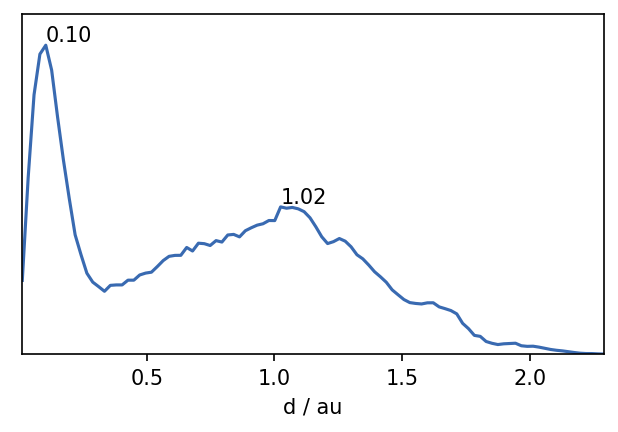

In [30]:
# Distance distribution for this cluster
robj1.calc_dist()
fig, ax, *_ = robj1.dist_hist(maxima=True, maxima_props={"order": 5})

And then we can attempt the second clustering step. For somewhat inhomogeneous data sets, a typical artifact or side effect of the CNN clustering is, that very small clusters may be appear in the result. To filter those out because they are irrelevant, we can use the `member_cutoff` keyword argument of the `fit` method.

Execution time for call of fit: 0 hours, 0 minutes, 0.0472 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
678       0.180     6         2         None      4         0.494     0.117     
--------------------------------------------------------------------------------
Execution time for call of fit: 0 hours, 0 minutes, 0.0446 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
678       0.180     6         5         None      2         0.494     0.124     
--------------------------------------------------------------------------------


Text(0.5, 1.0, 'member cutoff 5')

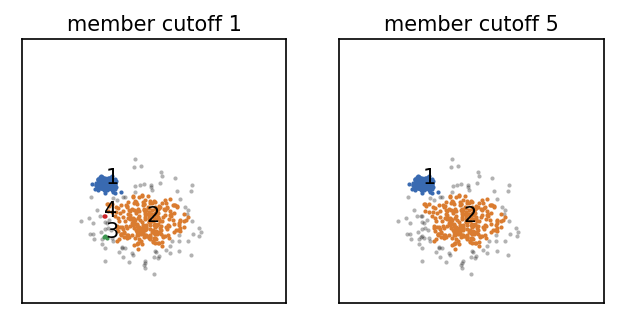

In [31]:
# Now cluster the child cluster
fig, Ax = plt.subplots(1, 2)
robj1.fit(0.18, 6)
_ = robj1.evaluate(ax=Ax[0], ax_props=ax_props)
Ax[0].set_title(f"member cutoff 1", fontsize=10, pad=4)

# When the result is satisfying, but also a few very small clusters are found,
# this can be surpressed
robj1.fit(0.18, 6, member_cutoff=5)
_ = robj1.evaluate(ax=Ax[1], ax_props=ax_props)
Ax[1].set_title(f"member cutoff 5", fontsize=10, pad=4)

As a little extra feature a cluster object has a `pie` method that allows to visualize the current state and splitting on the different hierarchy levels as a pie-diagram (from level 0 in the middle to lower levels to the outside).

(-0.3, 0.3)

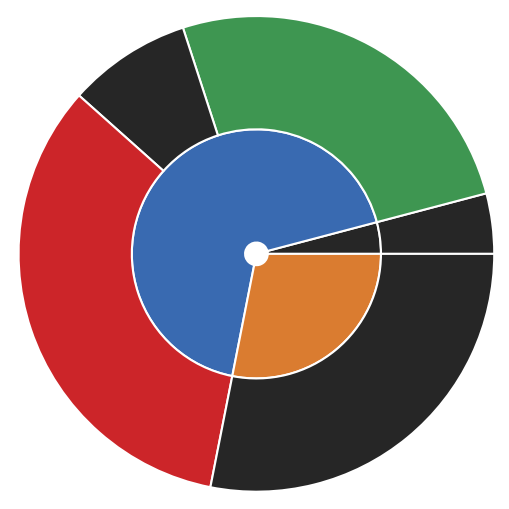

In [32]:
# The cluster hierarchy can be visualised as pie diagram
fig, ax, *plotted = robj.pie()
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.3, 0.3)

Now that we have isolated one cluster in the first step and two others in a further splitting on a lower hierarchy level, the last step that remains, is to put everything back together. This can be done automatically by calling `reel` on the parent cluster object into which the child cluster results should be integrated.

In [33]:
# Wrap up the hierarchical clustering and integrate the child clusters into
# the parent cluster
robj.reel()

# Manually sort clusters by size (largest = 1)
robj.labels.sort_by_size()  

(-0.3, 0.3)

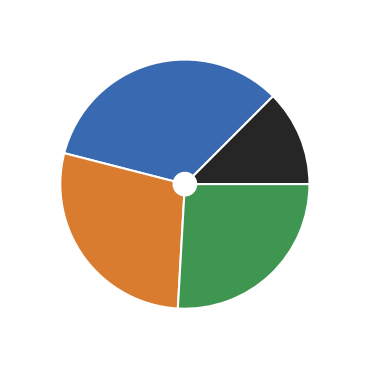

In [34]:
robj._children = None  # Remove child clusters 
fig, ax, *plotted = robj.pie()
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.3, 0.3)

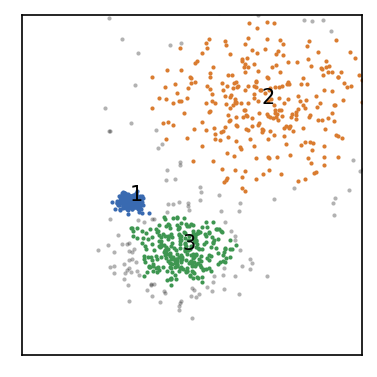

In [35]:
fig, ax = plt.subplots()
_ = robj.evaluate(ax=ax, ax_props=ax_props)

In [36]:
# Now the paramater information becomes useful as they differ
robj.labels.info

LabelInfo(origin='reeled', reference=<cnnclustering.cnn.CNN object at 0x7f90884c64c0>, params={2: (0.6, 17), 3: (0.18, 6), 1: (0.18, 6)})

In [37]:
print("Label", "r", "n", sep="\t")
print("-" * 20)
for k, v in sorted(robj.labels.info.params.items()):
    print(k, *v, sep="\t")

Label	r	n
--------------------
1	0.18	6
2	0.6	17
3	0.18	6


The cluster result is satisfying. But we have clustered only a reduced set of 1000 points. We would like to predict the cluster label assignment for the full 100,000 points on the basis of the reduced set assignments. This we can do with the `predict` method of a cluster object. We call `predict` with another cluster object for which labels should be predicted as an argument. Similar to a regular `fit` we need to compute neighbourhoods for the points that need assignment, but this time we need relative neighbourhood between two data sets. We want to compute the neighbouring points in the small set `robj` for the points in the big set `cobj`. To allow the fast computation of theses neighbourhoods we could calculate a relative pairwise distance matrix for distances from points in `cobj` to points in `robj` (a so called map matrix). When we predict labels afterwards we should do the prediction separately for the clusters because the assignment parameters differ. This is where the label info comes in handy showing us the parameters used for the fit as an orientation.

Distance matrix calculated in 0.29 seconds

Prediction in 2.74 seconds

Prediction in 4.73 seconds

Prediction in 2.46 seconds



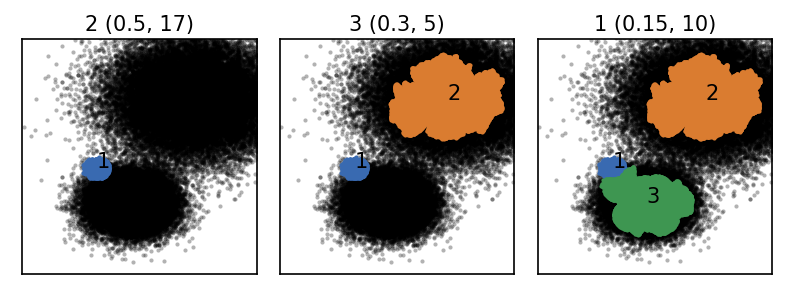

In [38]:
# In the end the cluster assignment for the reduced (train) set can
# be mapped onto another test set.
# The assignment prediction can (and should) be done
# for each cluster individually. 
go = time.time()
cobj.calc_dist(robj)  # Distance map calculation
print(f"Distance matrix calculated in {time.time()-go:.2f} seconds\n")
time.sleep(1)

fig, Ax = plt.subplots(1, 3)

go = time.time()
r = 0.15; n = 10
robj.predict(cobj, r, n, clusters=[1], purge=True, policy="progressive")
print(f"Prediction in {time.time()-go:.2f} seconds\n")
_ = cobj.evaluate(ax=Ax[0], ax_props=ax_props)
Ax[2].set_title(f'1 {(r, n)}', fontsize=10, pad=4)

go = time.time()
r = 0.5; n = 17
robj.predict(cobj, r, n, clusters=[2], policy="progressive")
print(f"Prediction in {time.time()-go:.2f} seconds\n")
time.sleep(1)
_ = cobj.evaluate(ax=Ax[1], ax_props=ax_props)
Ax[0].set_title(f'2 {(r, n)}', fontsize=10, pad=4)

go = time.time()
r = 0.3; n = 5
robj.predict(cobj, r, n, clusters=[3], policy="progressive")
print(f"Prediction in {time.time()-go:.2f} seconds\n")
_ = cobj.evaluate(ax=Ax[2], ax_props=ax_props)
Ax[1].set_title(f'3 {(r, n)}', fontsize=10, pad=4)


fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

In [39]:
print("Label", "r", "n", sep="\t")
print("-" * 20)
for k, v in sorted(cobj.labels.info.params.items()):
    print(k, *v, sep="\t")

Label	r	n
--------------------
1	0.15	10
2	0.5	17
3	0.3	5
